In [29]:
import pandas as pd

data = pd.read_csv('table.csv')
data.head()

,Unnamed: 0,partisan,level,type,candidates,mean gamma,stdev,total number of elections
0,0,DP,Federal,E,9,0.576628,NaN,1
1,1,Yes,Federal,R,3,0.914758,0.047078,3
2,2,Yes,State,E,4,0.815945,NaN,1
3,3,Yes,State,R,2,1.000000,0.000000,20
4,4,Yes,State,R,1,1.000000,0.000000,6


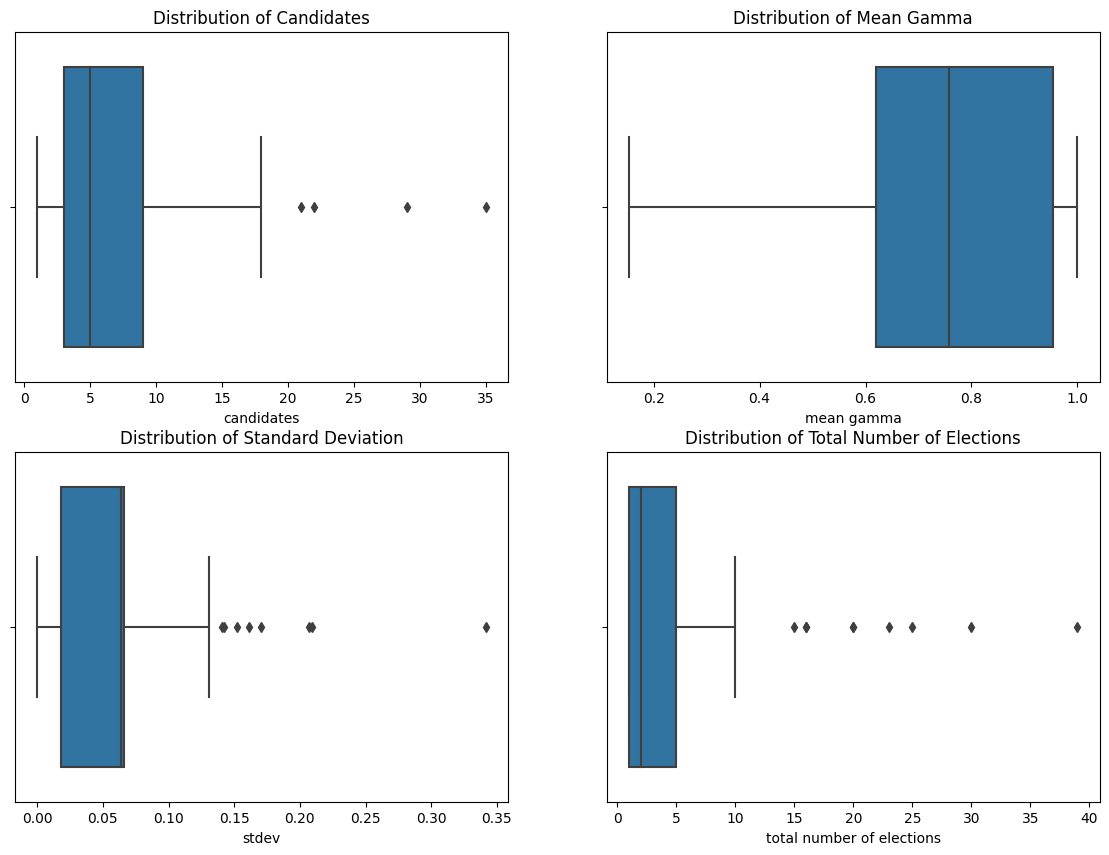

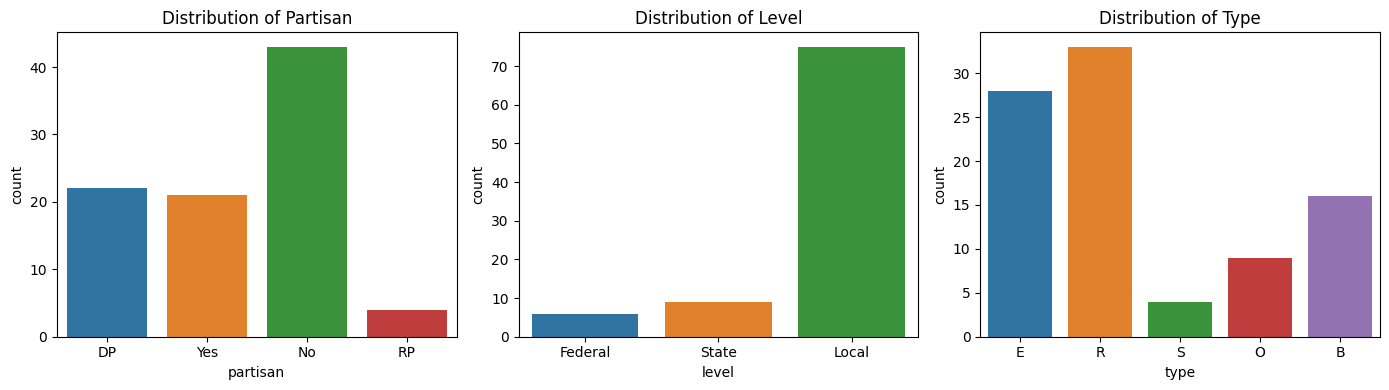

,Unnamed: 0,partisan,level,type,candidates,mean gamma,stdev,total number of elections
count,90.000000,90,90,90,90.000000,90.000000,90.000000,90.000000
unique,NaN,4,3,5,NaN,NaN,NaN,NaN
top,NaN,No,Local,R,NaN,NaN,NaN,NaN
freq,NaN,43,75,33,NaN,NaN,NaN,NaN
mean,46.722222,NaN,NaN,NaN,6.888889,0.757172,0.063883,4.877778
std,26.967741,NaN,NaN,NaN,5.944395,0.202370,0.054784,6.821690
min,0.000000,NaN,NaN,NaN,1.000000,0.153821,0.000000,1.000000
25%,24.250000,NaN,NaN,NaN,3.000000,0.619332,0.017887,1.000000
50%,46.500000,NaN,NaN,NaN,5.000000,0.758310,0.063883,2.000000
75%,69.750000,NaN,NaN,NaN,9.000000,0.953562,0.066201,5.000000


In [30]:
# Fill the missing values in 'stdev' column with the mean of the non-missing values.
data['stdev'].fillna(data['stdev'].mean(), inplace=True)

# Drop the rows that have the value 'DP' and 'RP' in the 'partisan' column.
#data = data[data['partisan'] != 'DP']
#data = data[data['partisan'] != 'RP']

# Summary statistics for each variable
summary = data.describe(include='all')

# Boxplots to visualize the distribution of numeric variables
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(x=data['candidates'], ax=axs[0, 0]).set_title('Distribution of Candidates')
sns.boxplot(x=data['mean gamma'], ax=axs[0, 1]).set_title('Distribution of Mean Gamma')
sns.boxplot(x=data['stdev'], ax=axs[1, 0]).set_title('Distribution of Standard Deviation')
sns.boxplot(x=data['total number of elections'], ax=axs[1, 1]).set_title('Distribution of Total Number of Elections')

# Bar plots to visualize the distribution of categorical variables
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

sns.countplot(x=data['partisan'], ax=axs[0]).set_title('Distribution of Partisan')
sns.countplot(x=data['level'], ax=axs[1]).set_title('Distribution of Level')
sns.countplot(x=data['type'], ax=axs[2]).set_title('Distribution of Type')

plt.tight_layout()
plt.show()

summary

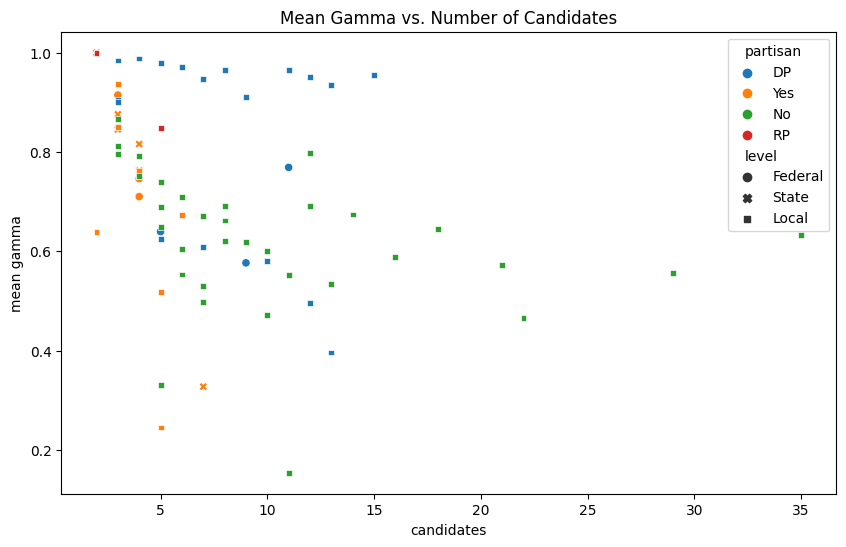

In [31]:
# Remove rows where the number of candidates is less than 2
filtered_data = data[data['candidates'] >= 2]

# Visualize the relationship between the number of candidates and mean gamma
plt.figure(figsize=(10, 6))
sns.scatterplot(x='candidates', y='mean gamma', hue='partisan', style='level', data=filtered_data)
plt.title('Mean Gamma vs. Number of Candidates')
plt.show()

<Figure size 1400x1000 with 0 Axes>

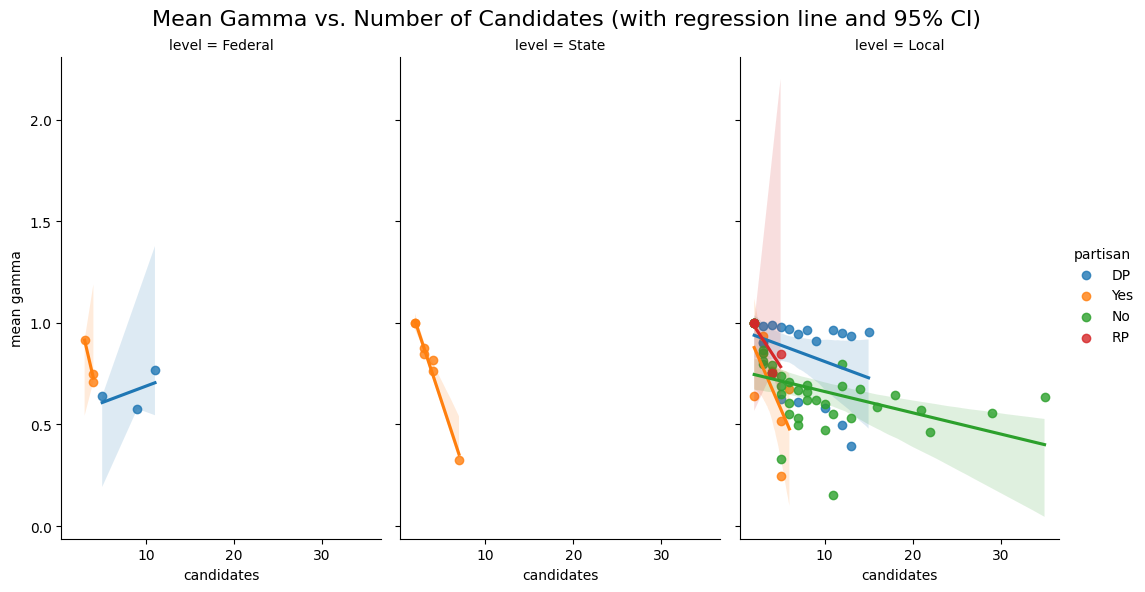

In [32]:
# Relationship between the number of candidates and mean gamma with a trend line for each category
plt.figure(figsize=(14, 10))

sns.lmplot(x='candidates', y='mean gamma', hue='partisan', col='level', data=filtered_data, ci=95, height=6, aspect=0.6)

plt.subplots_adjust(top=0.9)
plt.suptitle('Mean Gamma vs. Number of Candidates (with regression line and 95% CI)', fontsize=16)
plt.show()

In [33]:
# Drop the first level of each categorical variable to prevent multicollinearity
data_encoded = pd.get_dummies(filtered_data, columns=['partisan', 'level', 'type'], drop_first=True)

# Let's import the required function and fit a linear mixed-effects model
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Construct the formula for the initial model
formula = 'Q("mean gamma") ~ candidates + ' + ' + '.join(data_encoded.columns.difference(['Unnamed: 0', 'candidates', 'mean gamma', 'stdev', 'total number of elections']))

# Construct the formula with interaction terms
formula_interactions = formula + ' + candidates:partisan_No + candidates:partisan_RP + candidates:partisan_Yes + candidates:level_Local + candidates:level_State + candidates:type_E + candidates:type_O + candidates:type_R + candidates:type_S'

# Fit the model with interaction terms
mixed_model_interactions = smf.ols(formula_interactions, data=data_encoded)
mixed_model_interactions_fit = mixed_model_interactions.fit()

# Show the model summary
mixed_model_interactions_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q("mean gamma")   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     3.897
Date:                Tue, 01 Aug 2023   Prob (F-statistic):           2.20e-05
Time:                        10:53:49   Log-Likelihood:                 49.483
No. Observations:                  84   AIC:                            -58.97
Df Residuals:                      64   BIC:                            -10.35
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           0.9461      0.203      4.660      0.000       0.541       1.352
level_Local[T.True]                 0.0168      0.174      0.096      0.923      -0.331       0.365
level_State[T.True]                 0.1135      0.273      0.416      0.679      -0.432       0.659
partisan_No[T.True]                -0.2099      0.097     -2.160      0.035      -0.404      -0.016
partisan_RP[T.True]                 0.2450      0.222      1.103      0.274      -0.199       0.689
partisan_Yes[T.True]                0.1501      0.171      0.877      0.384      -0.192       0.492
type_E[T.True]                     -0.1004      0.091     -1.108      0.272      -0.281       0.081
type_O[T.True]                      0.2234      0.141      1.588      0.117      -0.058       0.504
type_R[T.True]                     -0.0107      0.108     -0.099      0.922      -0.226       0.205
type_S[T.True]                     -0.0067      0.429     -0.016      0.988      -0.863       0.850
candidates                         -0.0252      0.026     -0.984      0.329      -0.076       0.026
candidates:partisan_No[T.True]      0.0144      0.012      1.164      0.249      -0.010       0.039
candidates:partisan_RP[T.True]     -0.0650      0.060     -1.083      0.283      -0.185       0.055
candidates:partisan_Yes[T.True]    -0.0830      0.040     -2.064      0.043      -0.163      -0.003
candidates:level_Local[T.True]     -0.0011      0.025     -0.044      0.965      -0.051       0.049
candidates:level_State[T.True]     -0.0083      0.061     -0.135      0.893      -0.130       0.114
candidates:type_E[T.True]           0.0080      0.007      1.124      0.265      -0.006       0.022
candidates:type_O[T.True]          -0.0300      0.025     -1.199      0.235      -0.080       0.020
candidates:type_R[T.True]           0.0188      0.013      1.435      0.156      -0.007       0.045
candidates:type_S[T.True]           0.0117      0.129      0.091      0.928      -0.246       0.270
==============================================================================
Omnibus:                       13.200   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.884
Skew:                          -0.700   Prob(JB):                     0.000131
Kurtosis:                       4.774   Cond. No.                         437.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

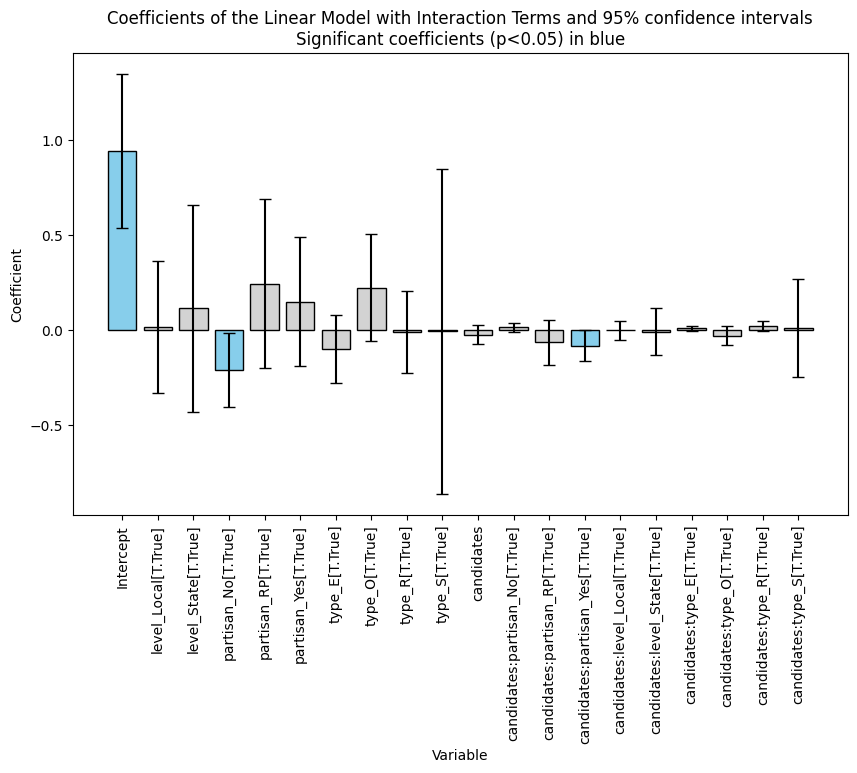

In [34]:
# Get the coefficients and their errors
coefficients_interactions = mixed_model_interactions_fit.params
errors_interactions = mixed_model_interactions_fit.bse

# Get the p-values from the model
p_values_interactions = mixed_model_interactions_fit.pvalues

# Create a new dataframe that includes coefficients, errors and p-values
df_interactions = pd.DataFrame({'coef': coefficients_interactions, 'err': errors_interactions, 'p_value': p_values_interactions})

# Create a new column in the dataframe to hold the colors for each bar
df_interactions['color'] = ['skyblue' if p < 0.05 else 'lightgray' for p in df_interactions['p_value']]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(df_interactions.index, df_interactions['coef'], yerr=df_interactions['err']*2, capsize=4, color=df_interactions['color'], edgecolor='black')
plt.title('Coefficients of the Linear Model with Interaction Terms and 95% confidence intervals\nSignificant coefficients (p<0.05) in blue')
plt.ylabel('Coefficient')
plt.xlabel('Variable')
plt.xticks(rotation=90)
plt.show()